# Imports
Run this code to import necessary modules.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd;
import seaborn as sns


# Variables
lets define some variables here so we can change them easier later 

In [3]:
file_path= "car details v4.csv"
data= pd.read_csv(file_path)
data_EDA= pd.read_csv(file_path)
random_state= 42

# Question 1

first we need to import and split our data

In [4]:

min_price= min(data['Price'])
max_price= max(data['Price'])
print("minimum price:", min_price)
print("maximum price:", max_price)
# categorized in 3 types of Price and add to our dataset
price_bins = pd.qcut(data['Price'], q=3, labels=False)
data['Price_Category'] = price_bins
#split our data to train and test I set random_state to avoid changing my shuffled data every time
train_set, test_set = train_test_split(data, test_size=0.2, stratify=data['Price_Category'], random_state= random_state)

minimum price: 49000
maximum price: 35000000


# Question 2
in this question we need to find some interesting information about our data and we don't have any specific roadmap for it so we will see what happens in the code.

histograms of features 

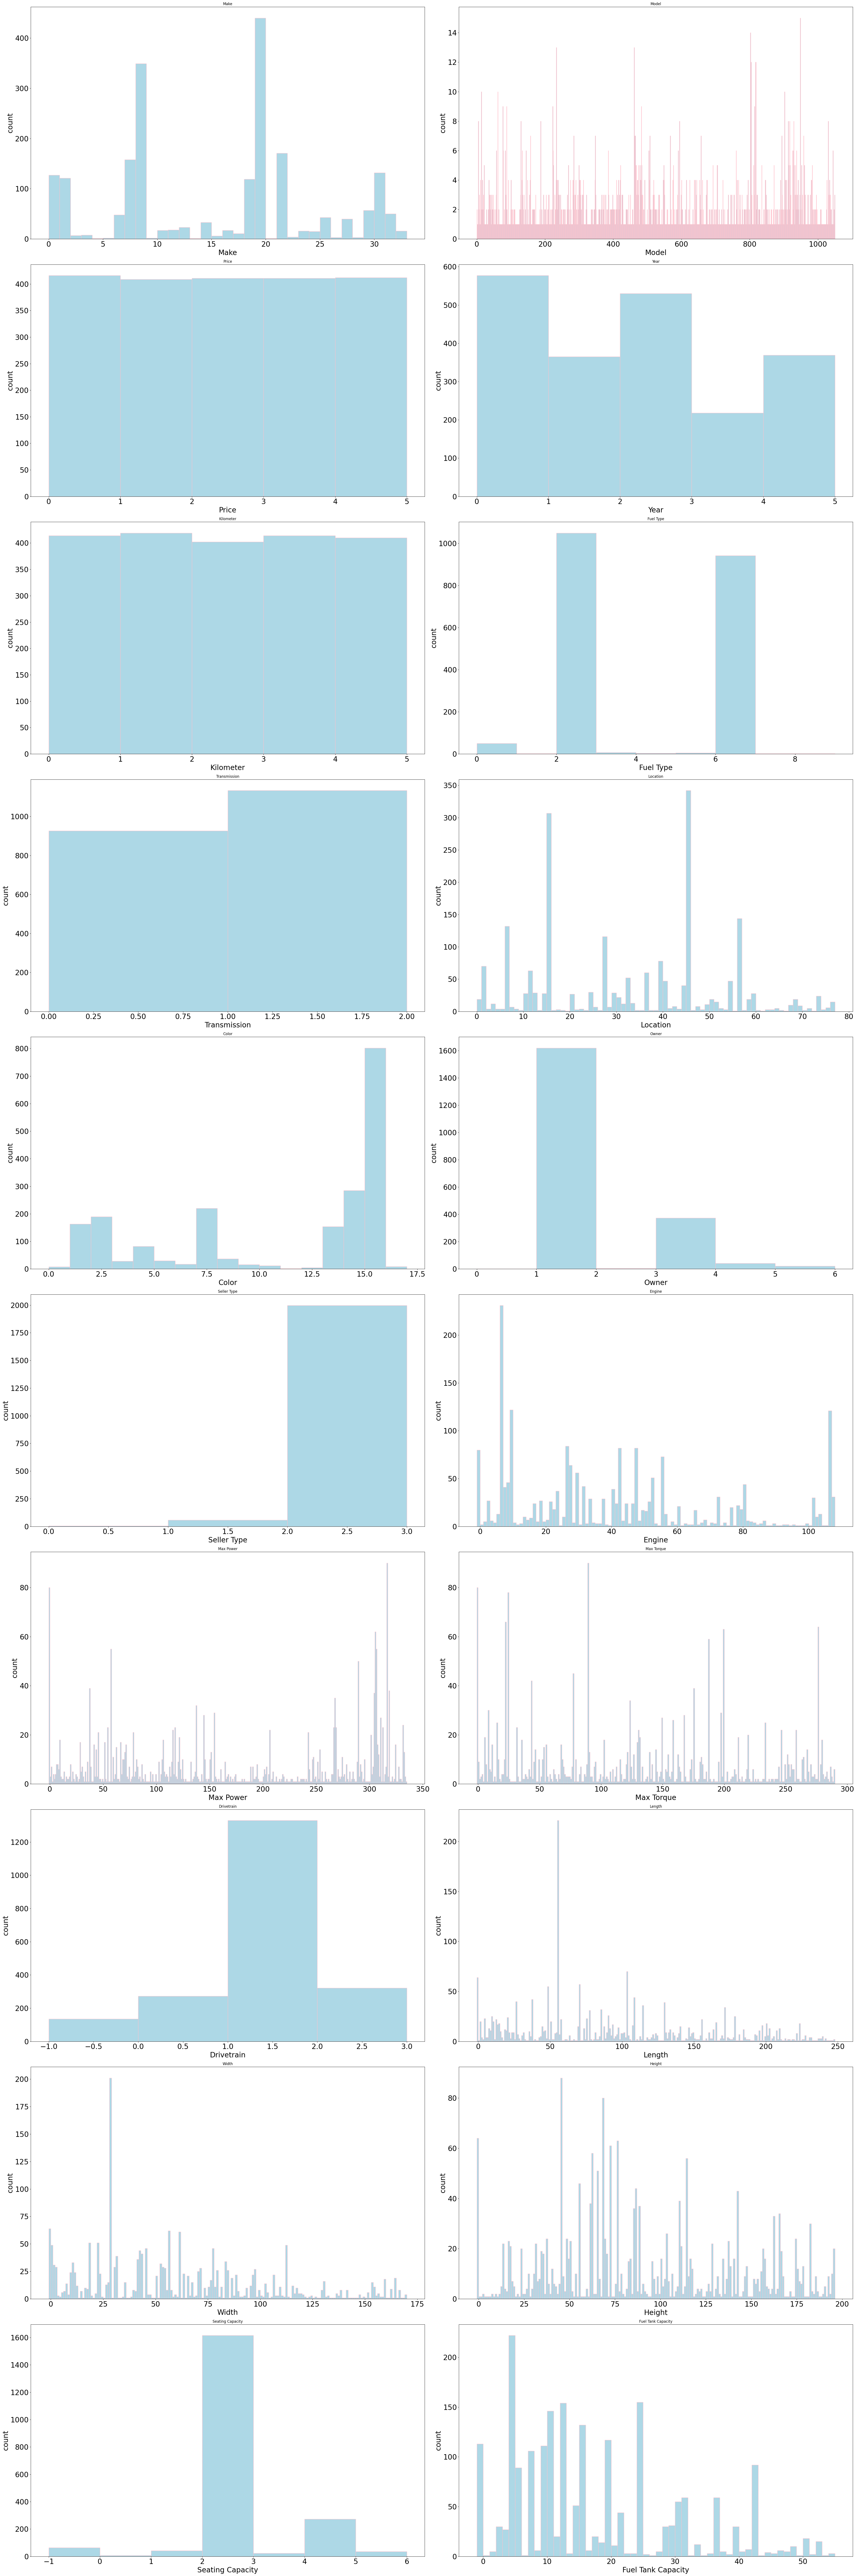

In [5]:
def categorized_data(local_data, q=0):
    if(local_data.dtype == 'int'):
        calculated_bins = pd.qcut(local_data, q=q, labels=False, duplicates="drop")
    else:
        calculated_bins= local_data.astype('category').cat.codes
    return calculated_bins

plt.figure(figsize=(40, 120))

def draw_hist(data, name, i):
    plt.subplot(10, 2, i)
    plt.hist(data, bins=range(min(data, default=0), max(data, default= 0) + 2), edgecolor='pink', color='lightblue')
    plt.title(name)
    plt.ylabel('count', fontsize=24)
    plt.xlabel(name, fontsize=24)
    plt.yticks(fontsize=24)
    plt.xticks(fontsize=24)

for i, column in enumerate(data.columns):
    fixed_data= categorized_data(data[column], 5)
    if(i==20):
        break
    draw_hist(fixed_data, column, i+1)

plt.tight_layout()
plt.show()



In [7]:
print(data.describe())
print("--------------------------")
print(print(data.isnull().sum()))

              Price         Year     Kilometer       Length        Width  \
count  2.059000e+03  2059.000000  2.059000e+03  1995.000000  1995.000000   
mean   1.702992e+06  2016.425449  5.422471e+04  4280.860652  1767.991980   
std    2.419881e+06     3.363564  5.736172e+04   442.458507   135.265825   
min    4.900000e+04  1988.000000  0.000000e+00  3099.000000  1475.000000   
25%    4.849990e+05  2014.000000  2.900000e+04  3985.000000  1695.000000   
50%    8.250000e+05  2017.000000  5.000000e+04  4370.000000  1770.000000   
75%    1.925000e+06  2019.000000  7.200000e+04  4629.000000  1831.500000   
max    3.500000e+07  2022.000000  2.000000e+06  5569.000000  2220.000000   

            Height  Seating Capacity  Fuel Tank Capacity  Price_Category  
count  1995.000000       1995.000000         1946.000000     2059.000000  
mean   1591.735338          5.306266           52.002210        0.997572  
std     136.073956          0.822170           15.110198        0.815600  
min    1165.000

histograms

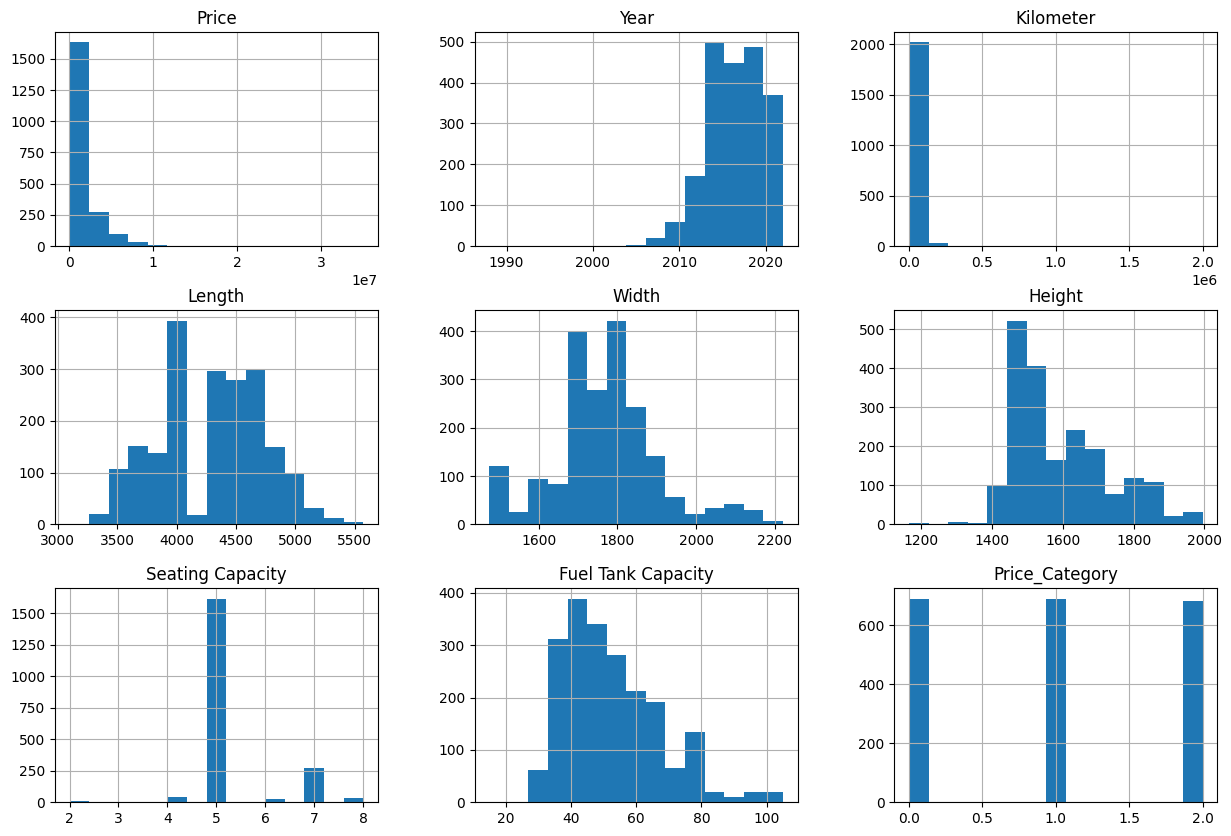

In [14]:
data.hist(bins=15, figsize=(15, 10))
plt.show()

box plots

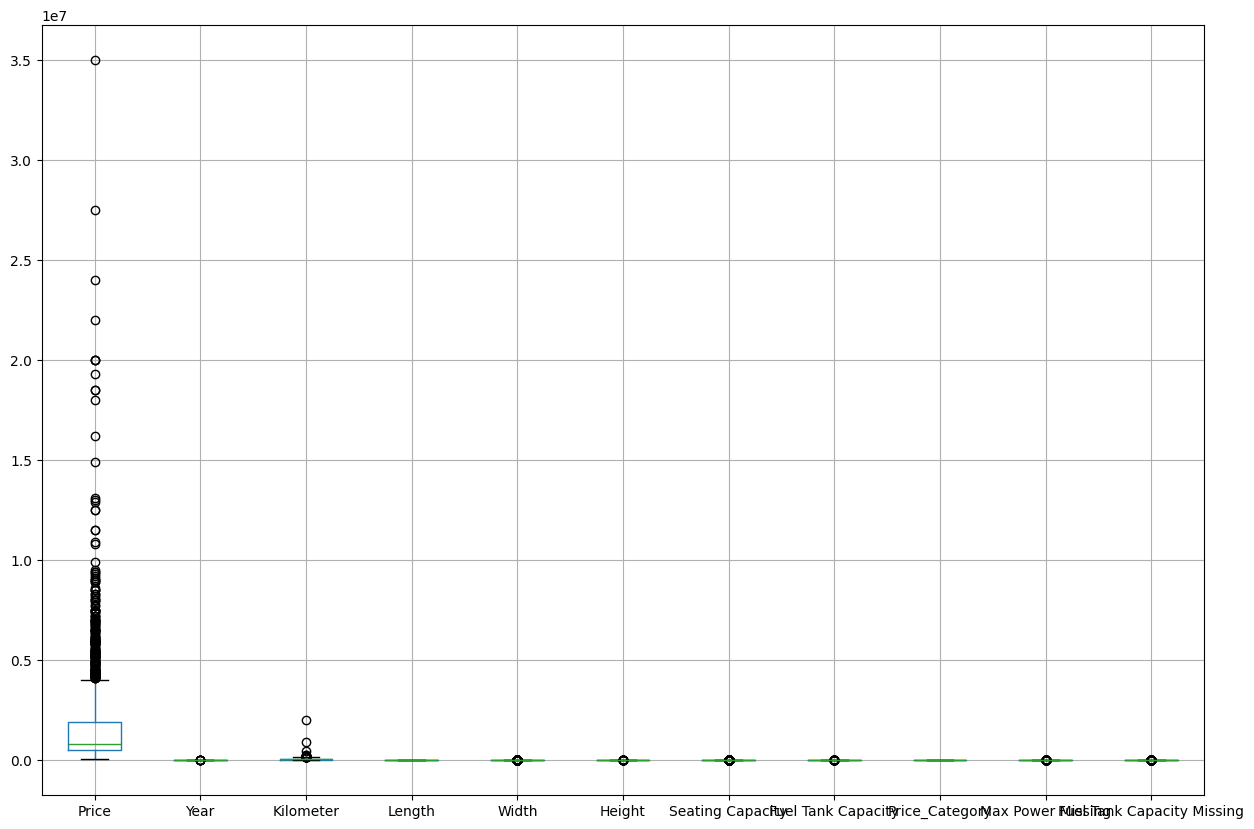

In [15]:
data.boxplot(figsize=(15, 10))
plt.show()

plots using price feature!

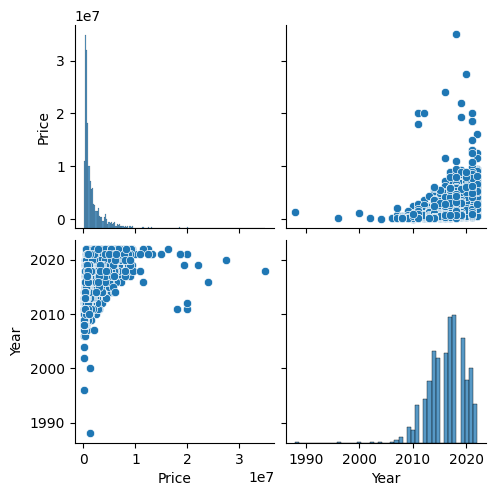

In [23]:
sns.pairplot(data[['Price', 'Year', 'Engine']])
plt.show()

categorized data analysis

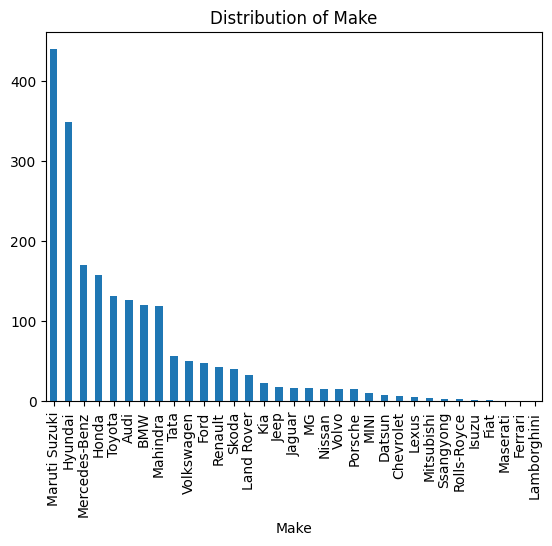

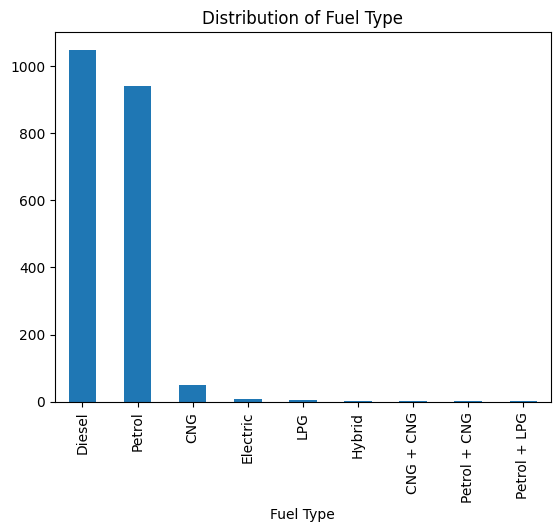

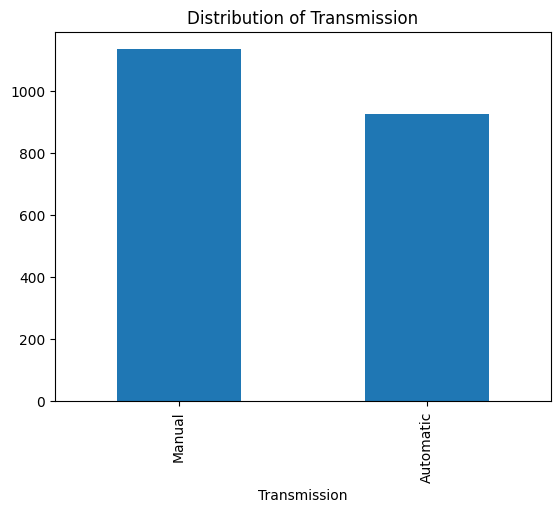

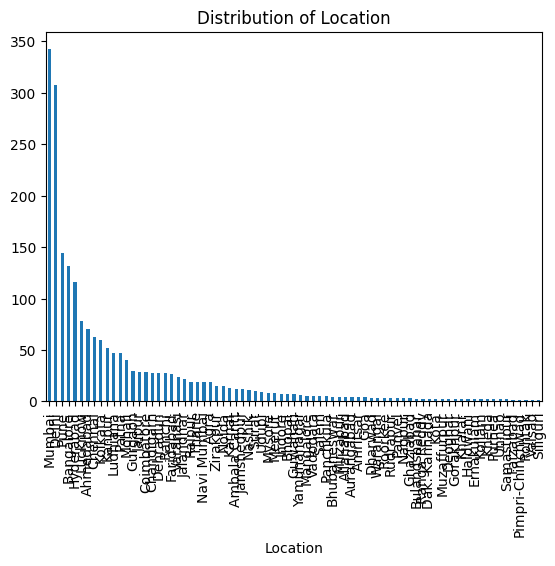

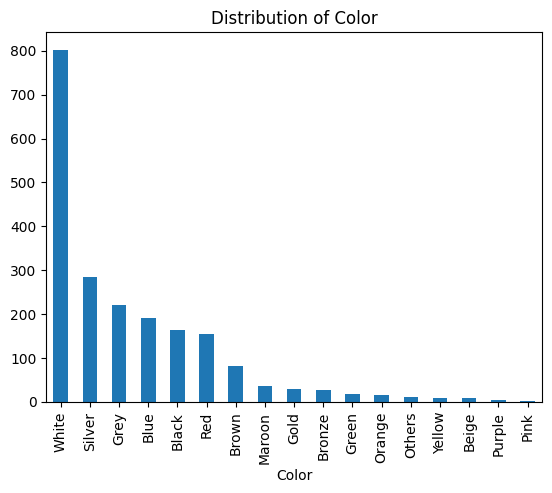

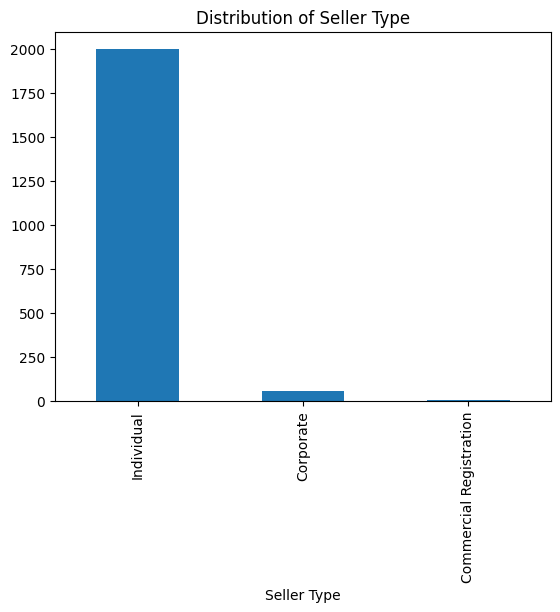

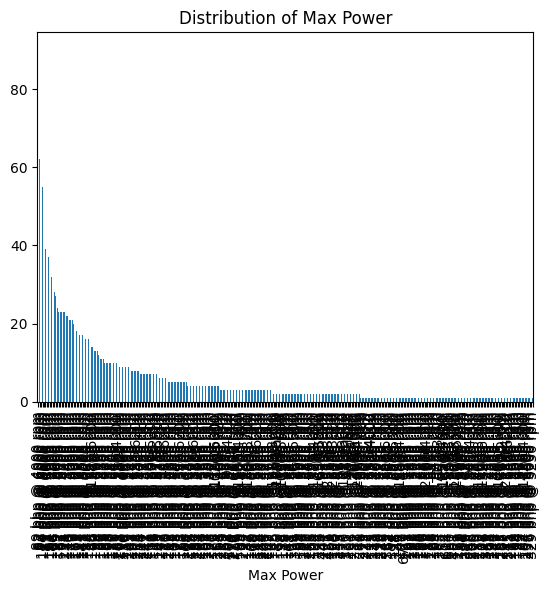

In [28]:
def draw_categorical(column):
    data[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.show()

cats= ["Make", "Fuel Type", "Transmission", "Location", "Color", "Seller Type", "Max Power"]
for i in cats:
    draw_categorical(i)



# Question 3
in this question we need to fill missing data

in the last question I printed the number of missing data in every column so no we want to go for them and use some ways to fill them.

In [13]:
updated_data = data
updated_data['Fuel Tank Capacity']=updated_data['Fuel Tank Capacity'].fillna(updated_data['Fuel Tank Capacity'].mean())
updated_data.info()
print("------------------")
print(print(updated_data.isnull().sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Make                        2059 non-null   object 
 1   Model                       2059 non-null   object 
 2   Price                       2059 non-null   int64  
 3   Year                        2059 non-null   int64  
 4   Kilometer                   2059 non-null   int64  
 5   Fuel Type                   2059 non-null   object 
 6   Transmission                2059 non-null   object 
 7   Location                    2059 non-null   object 
 8   Color                       2059 non-null   object 
 9   Owner                       2059 non-null   object 
 10  Seller Type                 2059 non-null   object 
 11  Engine                      1979 non-null   object 
 12  Max Power                   1979 non-null   object 
 13  Max Torque                  1979 